# Prediction: Thickness of melting zone

### Import of the dataset

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/tobias/PycharmProjects/melting-zone-thickness-prediction/data/welding_data.csv',
                  sep=',',
                  decimal=',',
                  thousands='.')
data = data.astype(dtype={'Nennleistung / W': np.float64, 'd_f / mm': np.float64, 'λ_K / W/(m*K)': np.float64,
                          'c_p_K / J/(kg*K)': np.float64, 'ρ_K / kg/m^3': np.float64, 'H_s_K / kJ/kg': np.float64,
                          'T_im_K / °C': np.float64, 't_M / mm': np.float64, 'λ_M / W/(m*K)': np.float64,
                          'c_p_M / J/(kg*K)': np.float64, 'ρ_M / kg/m^3': np.float64})
y = 'Schmelzzonendicke / µm'
features = ['Fügezeit', 'Nennleistung / W', 'd_f / mm', 'λ_K / W/(m*K)', 'c_p_K / J/(kg*K)', 'ρ_K / kg/m^3', 'H_s_K / kJ/kg', 'T_im_K / °C', 't_M / mm', 'λ_M / W/(m*K)', 'c_p_M / J/(kg*K)', 'ρ_M / kg/m^3']
columns = ['Schmelzzonendicke / µm', 'Fügezeit', 'Nennleistung / W', 'd_f / mm', 'λ_K / W/(m*K)', 'c_p_K / J/(kg*K)', 'ρ_K / kg/m^3', 'H_s_K / kJ/kg', 'T_im_K / °C', 't_M / mm', 'λ_M / W/(m*K)', 'c_p_M / J/(kg*K)', 'ρ_M / kg/m^3']

### Calculation of Realleistung

In [2]:
data['Realleistung'] = (data['Nennleistung / W']*data['ρ_M / kg/m^3'])/1000
#data.drop(labels=['Nennleistung / W', 'ρ_M / kg/m^3'], inplace=True, axis=1)

In [3]:
train_data = data[data['data_type']=='train']
validation_data = data[data['data_type']=='validation']

### Visualization of data

Populating the interactive namespace from numpy and matplotlib


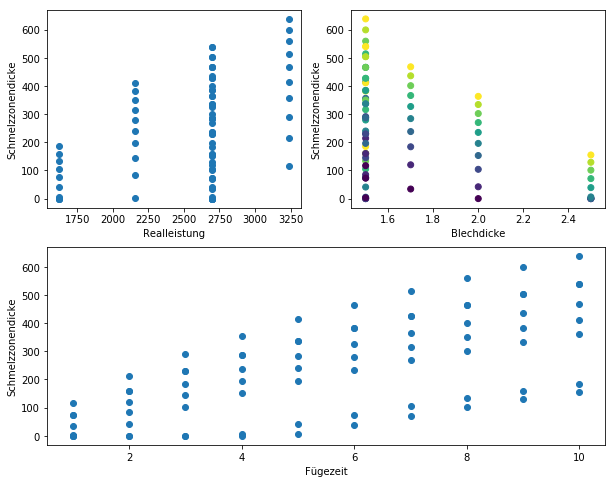

In [4]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

#plt.title('Realleistung, Fügezeit und Blechdicke über Schmelzzonendicke')
plt.subplot(221)
plt.scatter(x=train_data['Realleistung'], y=train_data[y])
plt.xlabel('Realleistung')
plt.ylabel('Schmelzzonendicke')
plt.subplot(212)
plt.scatter(x=train_data['Fügezeit'], y=train_data[y])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')
plt.subplot(222)
plt.scatter(x=train_data['t_M / mm'], y=train_data[y], c=train_data['Fügezeit'])
plt.xlabel('Blechdicke')
plt.ylabel('Schmelzzonendicke')
plt.show()

Text(0, 0.5, 'Schmelzzonendicke')

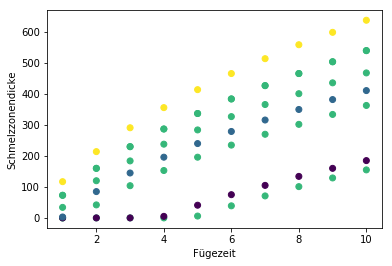

In [5]:
plt.scatter(x=train_data['Fügezeit'], y=train_data[y], c=train_data['Realleistung'])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')

Text(0, 0.5, 'Schmelzzonendicke')

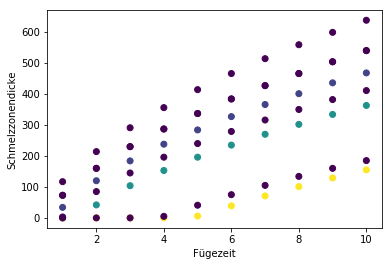

In [6]:
plt.scatter(x=train_data['Fügezeit'], y=train_data[y], c=train_data['t_M / mm'])
plt.xlabel('Fügezeit')
plt.ylabel('Schmelzzonendicke')

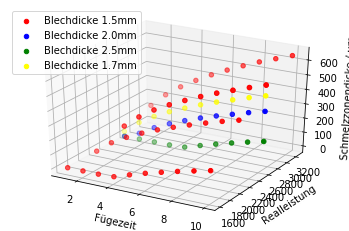

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['red', 'blue', 'green', 'yellow']


blechdicken = list(set(train_data['t_M / mm']))

i=0
for blechdicke in blechdicken:
    data = train_data[train_data['t_M / mm']==blechdicke]
    ax.scatter(xs=data['Fügezeit'], zs=data[y], ys=data['Realleistung'], c=color[i], label=data['t_M / mm'])
    plt.xlabel('Fügezeit')
    plt.ylabel('Realleistung')
    ax.set_zlabel(y)
    blechdicken[i] = 'Blechdicke ' + str(blechdicken[i]) + 'mm'
    i+=1

ax.legend(blechdicken)
plt.show()

### Data Cleaning

In [8]:
train_data = train_data[train_data[y]>0]

### Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler


feature_scaler = MinMaxScaler()
feature_scaler.fit(train_data[features])

scaled_data = feature_scaler.transform(train_data[features])
scaled_data = pd.DataFrame(scaled_data, columns=features)

y_scaler = MinMaxScaler()
y_scaler.fit(train_data[y].values.reshape(-1,1))
y_scaled = y_scaler.transform(train_data[y].values.reshape(-1,1))

X_train = scaled_data[features]
y_train = y_scaled


## Linear Regression

### Training

In [10]:
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
print(linear_regression_model.coef_)

[[ 0.63688241  0.58485352  0.          0.          0.          0.
   0.          0.         -0.49478929  0.          0.          0.        ]]


In [11]:
from sklearn.metrics import mean_absolute_error as mae

y_pred = linear_regression_model.predict(X_train)
print("Linear Regression - Mean Absolute Error:", mae(y_pred=y_pred, y_true=y_train))

Linear Regression - Mean Absolute Error: 0.04806225497079562


In [12]:
y_pred_linear_regression = linear_regression_model.predict(X_train)

## Support Vector Regression

### Grid Search with Cross Validation

In [50]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
             'degree': [1, 2, 3, 5],
              'coef0': [0.0],
             'gamma': ['auto'],
             'C': [0.1, 0.5, 1.0, 2.0, 100],
             'epsilon': [0.01, 0.05, 0.1, 0.3, 0.6, 1]}

welding_thickness_grid_search_cv = GridSearchCV(estimator=SVR(),
                                                param_grid=param_grid,
                                                cv=3,
                                                n_jobs=-1)

welding_thickness_grid_search_cv_fitted = welding_thickness_grid_search_cv.fit(X_train, y_train)
welding_thickness_predictor = welding_thickness_grid_search_cv_fitted.best_estimator_
print("Best score:", -welding_thickness_grid_search_cv_fitted.best_score_)
print("Parameters:", welding_thickness_predictor)

Best score: -0.9589467205955869
Parameters: SVR(C=100, cache_size=200, coef0=0.0, degree=1, epsilon=0.01, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


/Users/tobias/PycharmProjects/melting-zone-thickness-prediction/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
y_pred_svr = welding_thickness_predictor.predict(X_train)

## Neural Network

In [52]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'hidden_layer_sizes': [(10,), (10, 25, 20, 5), (100, 50, 25)],
              'learning_rate': ['constant', 'invscaling', 'adaptive'],
              'max_iter': [1000],
              'solver': ['lbfgs', 'sgd', 'adam']
             }

welding_thickness_grid_search_cv = GridSearchCV(estimator=MLPRegressor(),
                                                param_grid=param_grid,
                                                cv=3,
                                                n_jobs=-1)

welding_thickness_grid_search_cv_fitted = welding_thickness_grid_search_cv.fit(X_train, y_train)
neural_network = welding_thickness_grid_search_cv_fitted.best_estimator_
print("Best score:", -welding_thickness_grid_search_cv_fitted.best_score_)
print("Parameters:", welding_thickness_predictor)

Best score: -0.9670093557686312
Parameters: SVR(C=100, cache_size=200, coef0=0.0, degree=1, epsilon=0.01, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


/Users/tobias/PycharmProjects/melting-zone-thickness-prediction/venv/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
y_pred_nn = neural_network.predict(X_train)

In [54]:
predicted_data = train_data.copy()
predicted_data['y_pred_linear_regression'] = list(y_scaler.inverse_transform(y_pred_linear_regression))
predicted_data['y_pred_svr'] = list(y_scaler.inverse_transform(y_pred_svr.reshape(-1,1)))
predicted_data['y_pred_nn'] = list(y_scaler.inverse_transform(y_pred_nn.reshape(-1,1)))
predicted_data['y_true'] = list(y_scaler.inverse_transform(y_train))


## Evaluation

In [55]:
print("Linear Regression - Mean Absolute Error:", mae(y_pred=predicted_data['y_pred_linear_regression'], y_true=predicted_data['y_true']))
print("Neural Network - Mean Absolute Error:", mae(y_pred=predicted_data['y_pred_nn'], y_true=predicted_data['y_true']))
print("Support Vector Regression - Mean Absolute Error:", mae(y_pred=predicted_data['y_pred_svr'], y_true=predicted_data['y_true']))

Linear Regression - Mean Absolute Error: 30.519531906455224
Neural Network - Mean Absolute Error: 2.5280935835418847
Support Vector Regression - Mean Absolute Error: 7.381641907791829


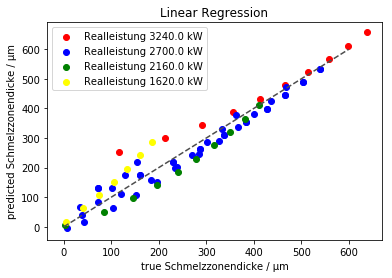

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['red', 'blue', 'green', 'yellow']
realleistungen = list(set(train_data['Realleistung']))

i=0
for realleistung in realleistungen:
    data = predicted_data[predicted_data['Realleistung']==realleistung]
    ax.scatter(x=data['y_true'], y=data['y_pred_linear_regression'], c=color[i], label=data['Realleistung'])
    realleistungen[i] = 'Realleistung ' + str(realleistungen[i]) + ' kW'
    i+=1
ax.legend(realleistungen)
ax.plot([0, 600], [0, 600], ls="--", c=".3")
plt.title("Linear Regression")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

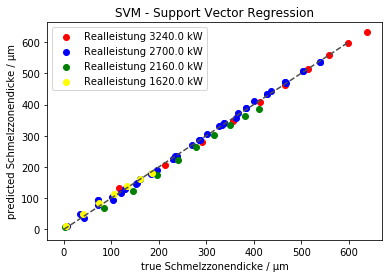

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['red', 'blue', 'green', 'yellow']
realleistungen = list(set(train_data['Realleistung']))

i=0
for realleistung in realleistungen:
    data = predicted_data[predicted_data['Realleistung']==realleistung]
    ax.scatter(x=data['y_true'], y=data['y_pred_svr'], c=color[i], label=data['Realleistung'])
    realleistungen[i] = 'Realleistung ' + str(realleistungen[i]) + ' kW'
    i+=1
ax.legend(realleistungen)
ax.plot([0, 600], [0, 600], ls="--", c=".3")
plt.title("SVM - Support Vector Regression")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

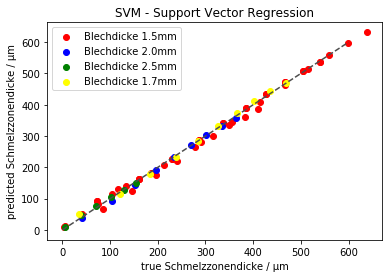

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['red', 'blue', 'green', 'yellow']
blechdicken = list(set(train_data['t_M / mm']))

i=0
for blechdicke in blechdicken:
    data = predicted_data[predicted_data['t_M / mm']==blechdicke]
    ax.scatter(x=data['y_true'], y=data['y_pred_svr'], c=color[i], label=data['t_M / mm'])
    blechdicken[i] = 'Blechdicke ' + str(blechdicken[i]) + 'mm'
    i+=1
ax.legend(blechdicken)
ax.plot([0, 600], [0, 600], ls="--", c=".3")
plt.title("SVM - Support Vector Regression")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

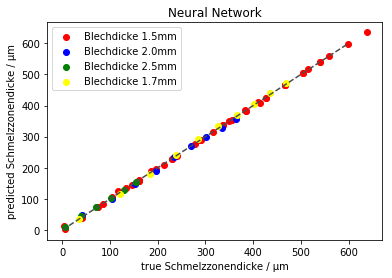

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)
color = ['red', 'blue', 'green', 'yellow']
blechdicken = list(set(train_data['t_M / mm']))

i=0
for blechdicke in blechdicken:
    data = predicted_data[predicted_data['t_M / mm']==blechdicke]
    ax.scatter(x=data['y_true'], y=data['y_pred_nn'], c=color[i], label=data['t_M / mm'])
    blechdicken[i] = 'Blechdicke ' + str(blechdicken[i]) + 'mm'
    i+=1
ax.legend(blechdicken)
ax.plot([0, 600], [0, 600], ls="--", c=".3")
plt.title("Neural Network")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

# Validation

In [60]:
X_validation = feature_scaler.transform(validation_data[features])
y_validation = y_scaler.transform(validation_data[y].values.reshape(-1,1))

y_validation_pred_lr = linear_regression_model.predict(X_validation)
y_validation_pred_nn = neural_network.predict(X_validation)
y_validation_pred_svr = welding_thickness_predictor.predict(X_validation)

predicted_validation = validation_data.copy()
predicted_validation['y_pred_lr'] = list(y_scaler.inverse_transform(y_validation_pred_lr))
predicted_validation['y_pred_svr'] = list(y_scaler.inverse_transform(y_validation_pred_svr.reshape(-1,1)))
predicted_validation['y_pred_nn'] = list(y_scaler.inverse_transform(y_validation_pred_nn.reshape(-1,1)))
predicted_validation['y_true'] = list(y_scaler.inverse_transform(y_validation))

print("Linear Regression - Mean Absolute Error:", mae(y_pred=predicted_validation['y_pred_lr'], y_true=predicted_validation['y_true']))
print("Neural Network - Mean Absolute Error:", mae(y_pred=predicted_validation['y_pred_nn'], y_true=predicted_validation['y_true']))
print("Support Vector Regression - Mean Absolute Error:", mae(y_pred=predicted_validation['y_pred_svr'], y_true=predicted_validation['y_true']))

Linear Regression - Mean Absolute Error: 33.39902433541835
Neural Network - Mean Absolute Error: 21.052382457974964
Support Vector Regression - Mean Absolute Error: 20.705927540773224


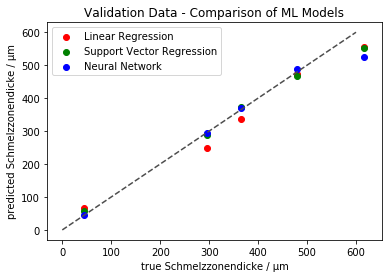

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['y_pred_lr'], c='red')
ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['y_pred_svr'], c='green')
ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['y_pred_nn'], c='blue')

ax.legend(['Linear Regression', 'Support Vector Regression', 'Neural Network'])
ax.plot([0, 600], [0, 600], ls="--", c=".3")
plt.title("Validation Data - Comparison of ML Models")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

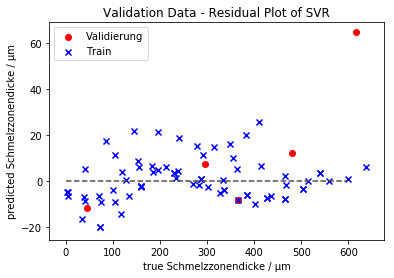

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)

predicted_validation['redidual_svr'] = predicted_validation['y_true'] - predicted_validation['y_pred_svr']
predicted_data['redidual_svr'] = predicted_data['y_true'] - predicted_data['y_pred_svr']


ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['redidual_svr'], c='red')
ax.scatter(x=predicted_data['y_true'], y=predicted_data['redidual_svr'], c='blue', marker='x')
ax.legend(['Validierung', 'Train'])


ax.plot([0, 600], [0, 0], ls="--", c=".3")
plt.title("Validation Data - Residual Plot of SVR")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

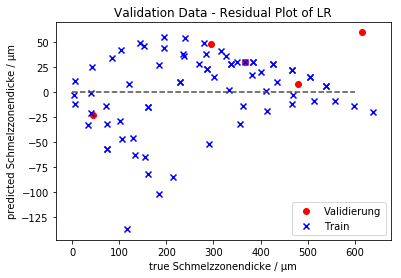

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)

predicted_validation['redidual_lr'] = predicted_validation['y_true'] - predicted_validation['y_pred_lr']
predicted_data['redidual_lr'] = predicted_data['y_true'] - predicted_data['y_pred_linear_regression']


ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['redidual_lr'], c='red')
ax.scatter(x=predicted_data['y_true'], y=predicted_data['redidual_lr'], c='blue', marker='x')
ax.legend(['Validierung', 'Train'])


ax.plot([0, 600], [0, 0], ls="--", c=".3")
plt.title("Validation Data - Residual Plot of LR")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()

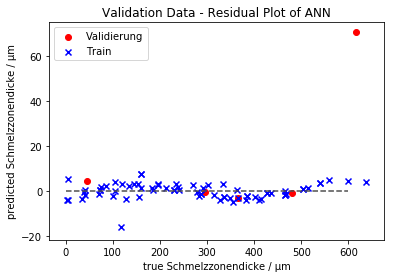

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

predicted_validation['redidual_nn'] = predicted_validation['y_true'] - predicted_validation['y_pred_nn']
predicted_data['redidual_nn'] = predicted_data['y_true'] - predicted_data['y_pred_nn']


ax.scatter(x=predicted_validation['y_true'], y=predicted_validation['redidual_nn'], c='red')
ax.scatter(x=predicted_data['y_true'], y=predicted_data['redidual_nn'], c='blue', marker='x')
ax.legend(['Validierung', 'Train'])


ax.plot([0, 600], [0, 0], ls="--", c=".3")
plt.title("Validation Data - Residual Plot of ANN")
plt.xlabel("true "+ y)
plt.ylabel("predicted "+ y)
plt.show()